# BDS Capstone Project #
Author: Christina Liu, cliu214 <br>
Due Date: October 20th, 2025 <br>



Dataset downloaded from: https://github.com/openmedlab/Awesome-Medical-Dataset/blob/main/resources/MSD_Brain.md

Task 1: Brain Segmentation was used for this data analysis


In [13]:
# import all modules here
import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
!pip install nilearn  #need to install
from nilearn import plotting, image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 77.2 MB/s eta 0:00:00


In [15]:
try:
    ## Mount Google Drive if using Google Colab
    from google.colab import drive
    drive.mount('/content/gdrive/')
    #data_dir = "gdrive/MyDrive/Task01_BrainTumour"
except:
    # Otherwise read from disk if using Anaconda
    # data_dir = "./Task01_BrainTumour"
    print("things went wrong")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [17]:
%cd /content/gdrive/MyDrive/
#!ls # tar file of data is in here

# extract data from tar file into google drive as folders and files (only needs to be run once)
#!tar -xvf Task01_BrainTumour.tar

/content/gdrive/MyDrive


In [18]:
!pwd

/content/gdrive/MyDrive


In [19]:
img_path = '/content/gdrive/MyDrive/Task01_BrainTumour/imagesTr/BRATS_001.nii.gz'
mask_path = '/content/gdrive/MyDrive/Task01_BrainTumour/imagesTr/BRATS_001.nii.gz'
lbl_path = '/content/gdrive/MyDrive/Task01_BrainTumour/labelsTr/BRATS_001.nii.gz'

# Load as nibabel objects
img = nib.load(img_path)
lbl = nib.load(lbl_path)

# Convert to numpy arrays
img_data = img.get_fdata()   # shape: (240, 240, 155, 4)
lbl_data = lbl.get_fdata()   # shape: (240, 240, 155)

print("Image shape:", img_data.shape)
print("Label shape:", lbl_data.shape)
print("Unique label values:", np.unique(lbl_data))


Image shape: (240, 240, 155, 4)
Label shape: (240, 240, 155)
Unique label values: [0. 1. 2. 3.]


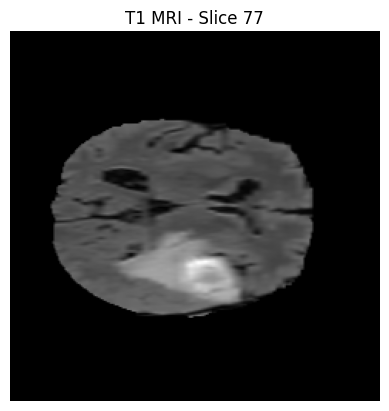

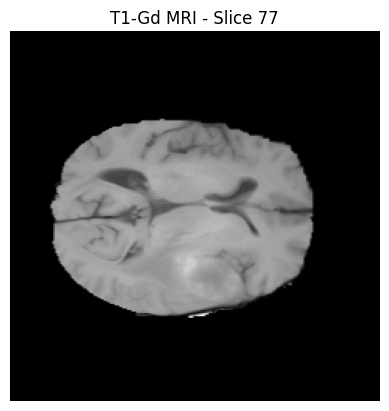

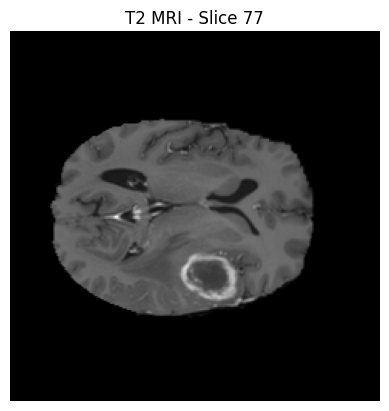

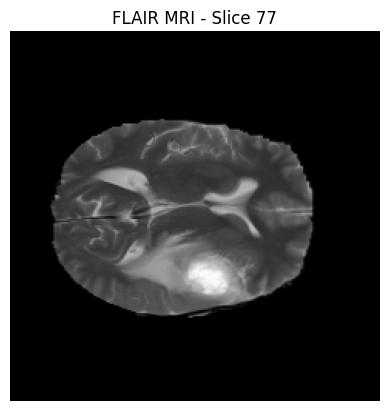

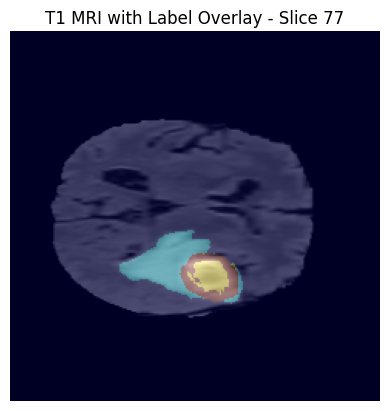

In [26]:
# Pick the middle slice along the Z-axis
slice_idx = img_data.shape[2] // 2

# Display T1 modality (channel 0)
plt.imshow(img_data[:, :, slice_idx, 0], cmap='gray')
plt.title(f"T1 MRI - Slice {slice_idx}")
plt.axis('off')
plt.show()

# Display Gadolinium (Gd) enhanced T1-weighted (T1-Gd) modality (channel 1)
plt.imshow(img_data[:, :, slice_idx, 1], cmap='gray')
plt.title(f"T1-Gd MRI - Slice {slice_idx}")
plt.axis('off')
plt.show()

# Display native T2-weighted (T2) modality (channel 2)
plt.imshow(img_data[:, :, slice_idx, 2], cmap='gray')
plt.title(f"T2 MRI - Slice {slice_idx}")
plt.axis('off')
plt.show()

# Display T2 Fluid Attenuated Inversion Recovery (FLAIR) modality (channel 3)
plt.imshow(img_data[:, :, slice_idx, 3], cmap='gray')
plt.title(f"FLAIR MRI - Slice {slice_idx}")
plt.axis('off')
plt.show()

# Overlay the mask
plt.imshow(img_data[:, :, slice_idx, 0], cmap='gray')
plt.imshow(lbl_data[:, :, slice_idx], alpha=0.3, cmap='jet')
plt.title(f"T1 MRI with Label Overlay - Slice {slice_idx}")
plt.axis('off')
#plt.legend()
plt.show()


In [27]:
images_dir = '/content/gdrive/MyDrive/Task01_BrainTumour/imagesTr'
labels_dir = '/content/gdrive/MyDrive/Task01_BrainTumour/labelsTr'

image_files = sorted(os.listdir(images_dir))
label_files = sorted(os.listdir(labels_dir))

print(f"Found {len(image_files)} images and {len(label_files)} labels")

records = []

Found 484 images and 484 labels


In [28]:
# Only include .nii.gz files that don't start with '._', so number of images and number of labels match
# google search says that these are hidden files that are not actually part of the data
# note, this part of the code is now redundant, as I removed the hidden files from the google folders
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.nii.gz') and not f.startswith('._')])
label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.nii.gz') and not f.startswith('._')])

print(len(image_files[:]), len(label_files))

484 484


In [35]:
records = []
modalities = ['T1','T1ce','T2','FLAIR']
patient_num = 1

for img_file, lbl_file in zip(image_files, label_files):
    # Load image and label
    img = nib.load(os.path.join(images_dir, img_file)).get_fdata()
    lbl = nib.load(os.path.join(labels_dir, lbl_file)).get_fdata()

    total_vox = int(np.sum(lbl > 0))
    r1 = int(np.sum(lbl == 1))  # enhancing tumor
    r2 = int(np.sum(lbl == 2))  # peritumoral edema
    r3 = int(np.sum(lbl == 3))  # necrotic core
    slices_with_tumor = int(np.sum(np.any(lbl > 0, axis=(0, 1))))

    # per-modality mean intensities within each region
    mean_int = {}
    for ch, mod in enumerate(modalities):
        vol = img[..., ch]
        for region_label, region_name in zip([1, 2, 3], ['r1', 'r2', 'r3']):
            mask = (lbl == region_label)
            mean_val = float(np.mean(vol[mask])) if np.sum(mask) > 0 else 0.0
            mean_int[f'mean_{mod}_{region_name}'] = mean_val

    # now append one record per patient
    rec = {
        'patient_file_name': img_file,
        'patient': patient_num,
        'total_tumor_voxels': total_vox,
        'region1_voxels': r1,
        'region2_voxels': r2,
        'region3_voxels': r3,
        'slices_with_tumor': slices_with_tumor
    }

    rec.update(mean_int)
    records.append(rec)
    patient_num += 1

# create dataframe
df = pd.DataFrame(records)

In [37]:
df # should show data for all patients

df_copy = df.copy() # just in case, because the data takes so long to load

In [38]:
df_copy

,patient_file_name,patient,total_tumor_voxels,region1_voxels,region2_voxels,region3_voxels,slices_with_tumor,mean_T1_r1,mean_T1_r2,mean_T1_r3,mean_T1ce_r1,mean_T1ce_r2,mean_T1ce_r3,mean_T2_r1,mean_T2_r2,mean_T2_r3,mean_FLAIR_r1,mean_FLAIR_r2,mean_FLAIR_r3
0,BRATS_001.nii.gz,1,111724,53050,27189,31485,74,911.163695,1042.464747,919.168366,900.669123,880.684468,916.781483,772.778077,638.100371,1278.966270,711.417361,1185.827541,829.115960
1,BRATS_002.nii.gz,2,63061,53736,1106,8219,61,1029.921766,987.371609,1007.296873,787.483531,754.409584,749.175569,705.267084,734.567812,1078.624164,755.534000,778.421338,818.611997
2,BRATS_003.nii.gz,3,173927,148263,4414,21250,82,904.372993,869.503625,882.120941,796.491431,846.485727,859.134400,409.514957,659.527413,1197.675624,795.329037,707.610331,708.953741
3,BRATS_004.nii.gz,4,120660,45189,57655,17816,73,839.456638,959.330639,1118.948361,784.506451,783.242234,728.176358,728.015712,612.394346,1059.077964,752.732435,969.648582,889.528233
4,BRATS_005.nii.gz,5,80680,35415,26912,18353,76,1058.623662,496.917435,929.237618,834.015050,527.677504,769.849180,753.402231,420.396960,1106.552716,575.576168,925.423491,610.901814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,BRATS_480.nii.gz,480,149604,87050,35617,26937,81,549.141620,611.844793,550.799681,291.365606,286.630907,328.432268,295.654474,296.532105,478.617923,891.747099,1212.537384,902.088503
480,BRATS_481.nii.gz,481,57168,37895,4159,15114,58,440.713867,383.078384,403.603679,404.106267,281.303438,311.777756,530.314659,620.382303,976.375480,954.039240,1075.657610,1016.164682
481,BRATS_482.nii.gz,482,184720,84679,72190,27851,74,429.912245,341.493102,342.324548,512.609207,365.067821,473.899393,777.250794,630.526250,1146.228466,915.251550,1107.483183,907.952964
482,BRATS_483.nii.gz,483,64347,20156,24733,19458,49,271.268109,208.702341,266.944650,493.830968,397.988841,467.148576,463.871254,226.880403,811.498201,487.241119,773.558444,582.254497


In [40]:
# compute percentages (percentage of tumor that is each specific type)
df_copy['region1_pct'] = df_copy['region1_voxels'] / df_copy['total_tumor_voxels'].replace(0, np.nan) * 100 # ET
df_copy['region2_pct'] = df_copy['region2_voxels'] / df_copy['total_tumor_voxels'].replace(0, np.nan) * 100 # ED
df_copy['region3_pct'] = df_copy['region3_voxels'] / df_copy['total_tumor_voxels'].replace(0, np.nan) * 100 # NCR

# replace NaN percentages with 0 for cases with no tumor of that type (this should only be NCR)
df_copy[['region1_pct','region2_pct','region3_pct']] = df_copy[['region1_pct','region2_pct','region3_pct']].fillna(0)

# basic stats
print(df_copy[['total_tumor_voxels','slices_with_tumor']].describe())

       total_tumor_voxels  slices_with_tumor
count          484.000000         484.000000
mean        103299.617769          69.741736
std          59269.356479          15.386579
min           7285.000000          27.000000
25%          57435.750000          58.750000
50%          94221.500000          72.000000
75%         147549.250000          80.000000
max         318345.000000         115.000000


In [60]:
print(df_copy[['region1_voxels','region2_voxels', 'region3_voxels']].describe())

       region1_voxels  region2_voxels  region3_voxels
count      484.000000      484.000000      484.000000
mean     64993.154959    18040.427686    20266.035124
std      42587.631695    19119.816200    19761.768319
min       3676.000000       47.000000        0.000000
25%      31204.750000     5513.250000     5589.750000
50%      54187.000000    11698.000000    14921.500000
75%      91021.250000    22951.250000    29438.000000
max     216095.000000   114471.000000   116726.000000


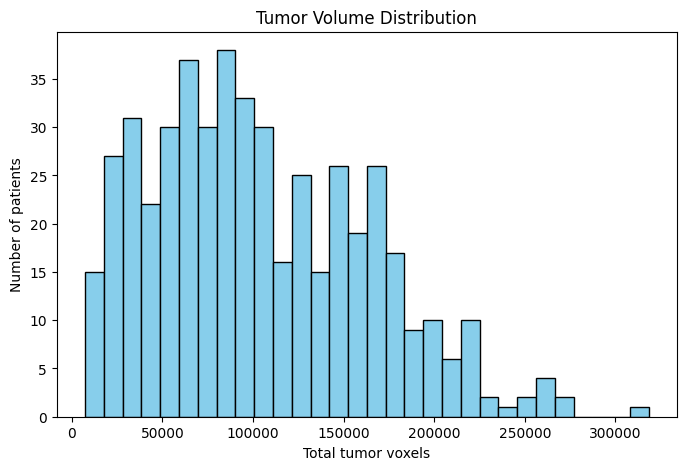

In [41]:
# Tumor Volume Distribution and Composition
plt.figure(figsize=(8,5))
plt.hist(df_copy['total_tumor_voxels'], bins=30, color='skyblue', edgecolor='k')
plt.xlabel('Total tumor voxels')
plt.ylabel('Number of patients')
plt.title('Tumor Volume Distribution')
plt.show()

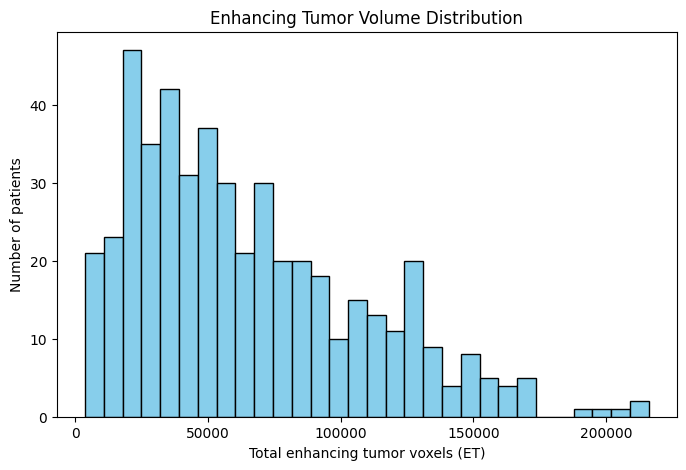

In [51]:
# Tumor Volume Distribution and Composition
plt.figure(figsize=(8,5))
plt.hist(df_copy['region1_voxels'], bins=30, color='skyblue', edgecolor='k')
plt.xlabel('Total enhancing tumor voxels (ET)')
plt.ylabel('Number of patients')
plt.title('Enhancing Tumor Volume Distribution')
plt.show()

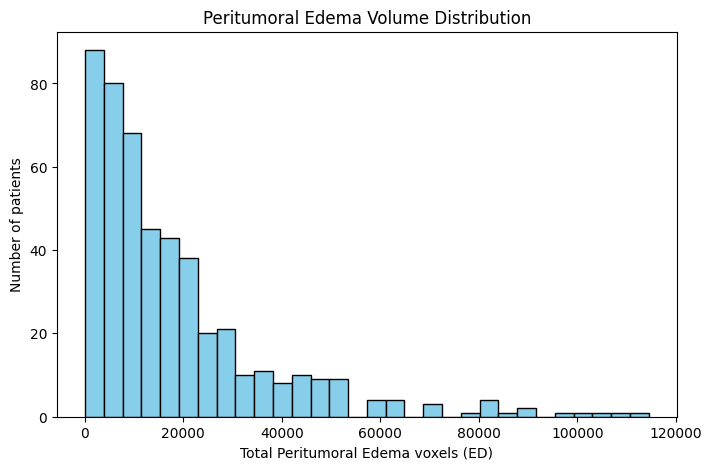

In [52]:
# Tumor Volume Distribution and Composition
plt.figure(figsize=(8,5))
plt.hist(df_copy['region2_voxels'], bins=30, color='skyblue', edgecolor='k')
plt.xlabel('Total Peritumoral Edema voxels (ED)')
plt.ylabel('Number of patients')
plt.title('Peritumoral Edema Volume Distribution')
plt.show()

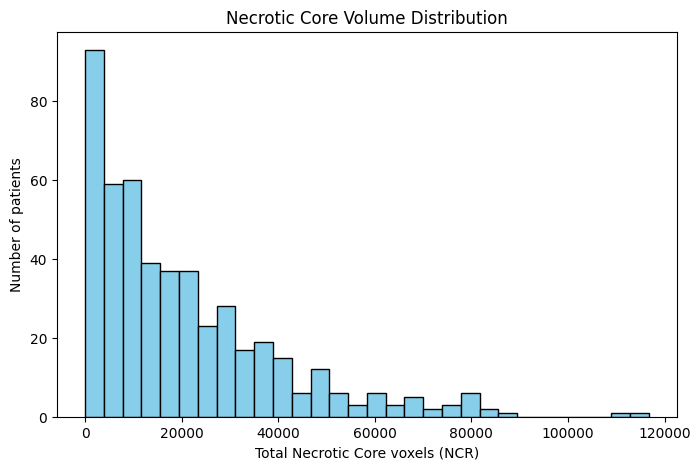

In [53]:
# Tumor Volume Distribution and Composition
plt.figure(figsize=(8,5))
plt.hist(df_copy['region3_voxels'], bins=30, color='skyblue', edgecolor='k')
plt.xlabel('Total Necrotic Core voxels (NCR)')
plt.ylabel('Number of patients')
plt.title('Necrotic Core Volume Distribution')
plt.show()

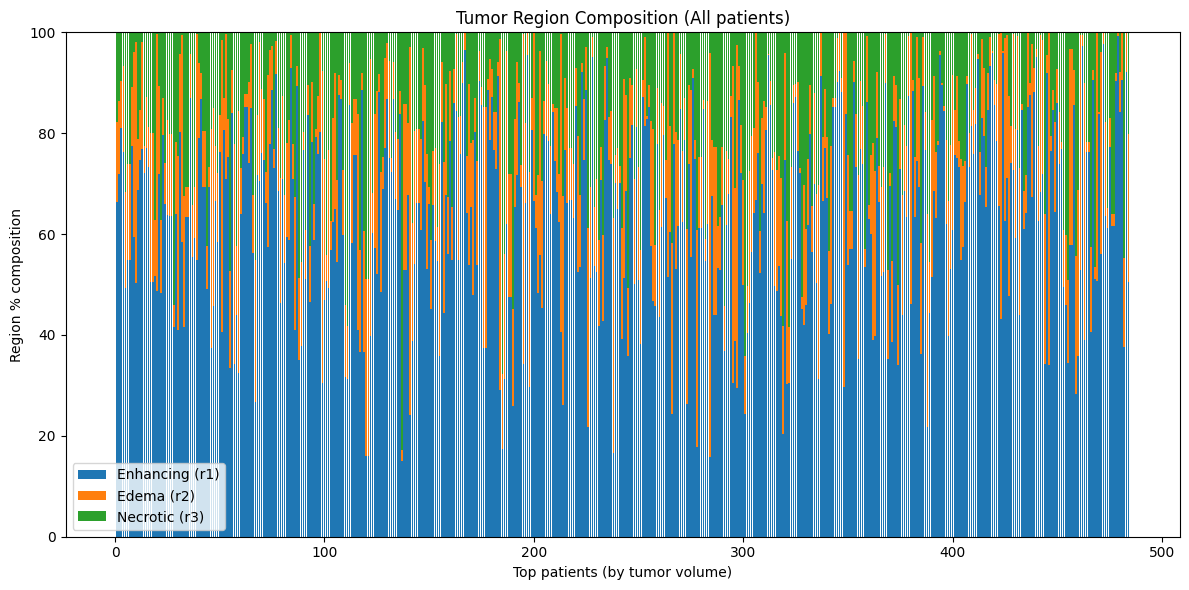

In [63]:
# stacked bar composition for all patients by volume
N = 484
df_sorted = df_copy.sort_values('total_tumor_voxels', ascending=False).head(N)
plt.figure(figsize=(12,6))
plt.bar(range(1, N+1), df_sorted['region1_pct'], label='Enhancing (r1)')
plt.bar(range(1, N+1), df_sorted['region2_pct'], bottom=df_sorted['region1_pct'], label='Edema (r2)')
plt.bar(range(1, N+1), df_sorted['region3_pct'], bottom=df_sorted['region1_pct']+df_sorted['region2_pct'], label='Necrotic (r3)')
plt.xlabel('Top patients (by tumor volume)')
plt.ylabel('Region % composition')
plt.title('Tumor Region Composition (All patients)')
plt.legend()
plt.tight_layout()
plt.show()

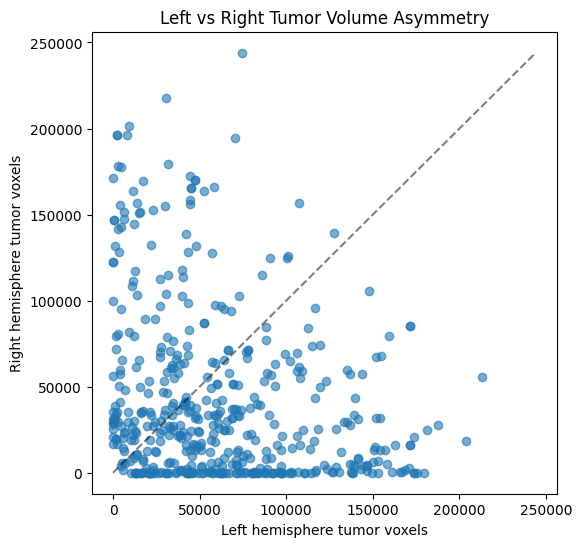

In [57]:
# left vs 4ight hemisphere asymmetry/symmetry

left_vol = []
right_vol = []
for lbl_fname in label_files:
  lbl = nib.load(os.path.join(labels_dir, lbl_fname)).get_fdata()
  mid = lbl.shape[1] // 2 # get midline dividing the hemispheres
  left_vol.append(np.sum(lbl[:, :mid, :] > 0))
  right_vol.append(np.sum(lbl[:, mid:, :] > 0))

left_vol = np.array(left_vol)
right_vol = np.array(right_vol)

plt.figure(figsize=(6,6))
plt.scatter(left_vol, right_vol, alpha=0.6)
maxv = max(left_vol.max(), right_vol.max())
plt.plot([0, maxv], [0, maxv], 'k--', alpha=0.5)
plt.xlabel('Left hemisphere tumor voxels')
plt.ylabel('Right hemisphere tumor voxels')
plt.title('Left vs Right Tumor Volume Asymmetry')
plt.show()

100%|██████████| 484/484 [00:46<00:00, 10.40it/s]


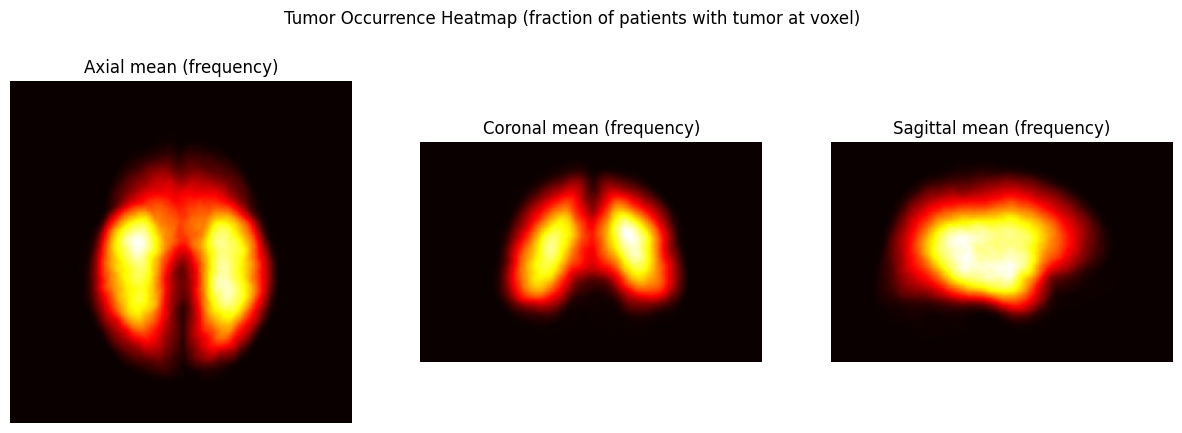

In [58]:
# build heatmap by summing across patients
sample_lbl = nib.load(os.path.join(labels_dir, label_files[0])).get_fdata()
heatmap = np.zeros_like(sample_lbl, dtype=np.float32)

for lbl_fname in tqdm(label_files):
  lbl = nib.load(os.path.join(labels_dir, lbl_fname)).get_fdata()
  heatmap += (lbl > 0).astype(np.float32)

# normalize
heatmap = heatmap / len(label_files)

# projections
axial_mean = np.mean(heatmap, axis=2)
coronal_mean = np.mean(heatmap, axis=1)
sagittal_mean = np.mean(heatmap, axis=0)

fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(np.rot90(axial_mean), cmap='hot')
axs[0].set_title('Axial mean (frequency)')
axs[1].imshow(np.rot90(coronal_mean), cmap='hot')
axs[1].set_title('Coronal mean (frequency)')
axs[2].imshow(np.rot90(sagittal_mean), cmap='hot')
axs[2].set_title('Sagittal mean (frequency)')
for ax in axs: ax.axis('off')
plt.suptitle('Tumor Occurrence Heatmap (fraction of patients with tumor at voxel)')
plt.show()

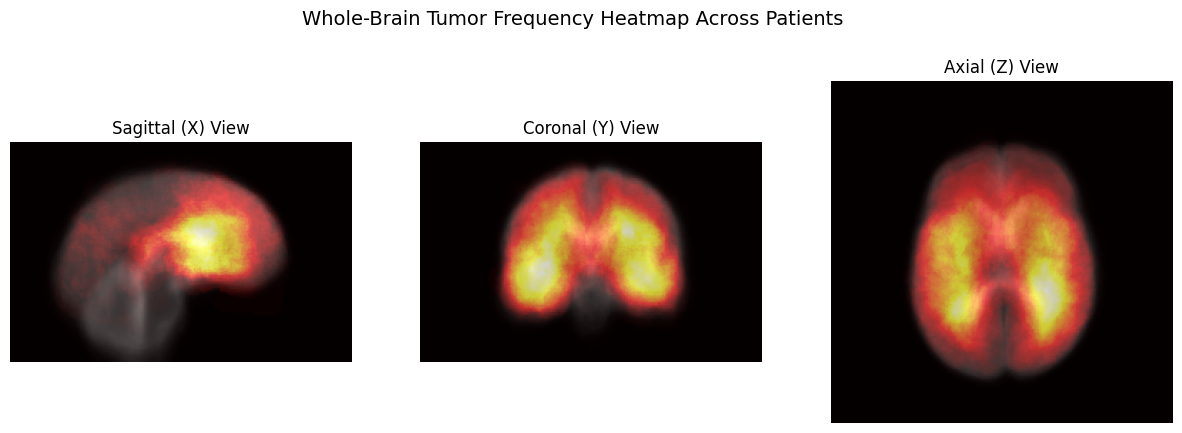

In [59]:
# accumulate tumor masks and average image
tumor_accum = None
brain_accum = None
n_patients = len(label_files)

for img_file, lbl_file in zip(image_files, label_files):
    lbl = nib.load(os.path.join(labels_dir, lbl_file)).get_fdata()
    img = nib.load(os.path.join(images_dir, img_file)).get_fdata()

    # binary tumor mask (any tumor region > 0)
    tumor_mask = (lbl > 0).astype(np.float32)
    # take one modality for brain visualization
    brain = img[..., 3]  # 4th channel = FLAIR

    if tumor_accum is None:
        tumor_accum = np.zeros_like(tumor_mask)
        brain_accum = np.zeros_like(brain)

    tumor_accum += tumor_mask
    brain_accum += brain

# normalize
tumor_freq = tumor_accum / n_patients
mean_brain = brain_accum / n_patients

# visualize middle slices (axial, coronal, sagittal)
slices = [tumor_freq.shape[0]//2, tumor_freq.shape[1]//2, tumor_freq.shape[2]//2]
titles = ['Sagittal (X)', 'Coronal (Y)', 'Axial (Z)']

plt.figure(figsize=(15,5))

for i, (s, t) in enumerate(zip(slices, titles)):
    plt.subplot(1,3,i+1)
    if i == 0:
        base = mean_brain[s,:,:]
        overlay = tumor_freq[s,:,:]
    elif i == 1:
        base = mean_brain[:,s,:]
        overlay = tumor_freq[:,s,:]
    else:
        base = mean_brain[:,:,s]
        overlay = tumor_freq[:,:,s]

    plt.imshow(base.T, cmap='gray', origin='lower')
    plt.imshow(overlay.T, cmap='hot', alpha=0.6, origin='lower')
    plt.title(f"{t} View")
    plt.axis('off')

plt.suptitle("Whole-Brain Tumor Frequency Heatmap Across Patients", fontsize=14)
plt.show()